# Step 1a: Customize your supply chain - defining facility template (optional)
- Facility templates are to define different types of facilities in a supply chain
- A facility template defines not only what kinds of agents it contains but also how they perform (class)
- In a facility template, you can also assign agents to different "agent_type" to group agents
- For example, the following codes define a store template of a retailer:
    - Each store can be seen as a facility with a list of "products" and "storage" capacity
    - Each product in the store has both "consumer" and "seller" behaviors to denote that it can place replenishing orders and be sold to customers.

In [ ]:
"""
    RetailerFacility: &retailer_facility             
    class: "RetailerFacility"                        
    children:
      storage:
        class: "StorageUnit"
      products:
        class: "StoreProductUnit"
        is_template: true
        config:
          agent_type: "productstore"
          consumer:
            class: "ConsumerUnit"
            config:
              agent_type: "consumerstore"
          seller:
            class: "SellerUnit"
            config:
              sale_hist_len: 4
    config:
      agent_type: "facility"
"""

# Step 1b: Instantiate all facilities in the supply chain
- Refer a facility template defined before
- Instantiate parameters of each sub-agent
- Below is an example showing how a supplier and a retailer can be instantiated.

In [ ]:
"""
    facilities:
        - name: "Supplier_001" # name of the facility
          definition_ref: "SupplierFacility"
          # sku list of this facility
          skus:
            sku1: # sku name and attributes needed for this facility
              init_stock: 1000
              product_unit_cost: 90
              production_rate: 1000
              type: "production"
              cost: 90
              price: 100
              vlt: 2
           sku2:
              init_stock: 1000
              product_unit_cost: 150
              production_rate: 1000
              type: "production"
              cost: 150
              price: 200
              vlt: 3
         children:
            storage: 
            distribution:
          # config of this facility
          config:
            delay_order_penalty: 100
            order_cost: 10
        
    - name: "Retailer_001"
          definition_ref: "RetailerFacility"
          skus:
            sku1:
              price: 200
              cost: 100
              init_stock: 40
              sale_gamma: 20
              backlog_ratio: 0.1
              vlt: 1
            sku2:
              price: 350
              cost: 200
              init_stock: 160
              sale_gamma: 80
              backlog_ratio: 0.1
              vlt: 1
         children:
            storage: *small_storage
"""




# In case we want to define a retailer store with demands of SKUs are sampled from historical data, this can be simply done by changing the "class" of seller, see below for instance.

In [ ]:
"""
    RetailerFacility: &raw_data_retailer_facility
        class: "OuterRetailerFacility"
        children:
          storage:
            class: "StorageUnit"
          products:
            class: "StoreProductUnit"
            is_template: true
            config:
              agent_type: "consumer"
              consumer:
                class: "ConsumerUnit"
              seller:
                class: "RawDataSellerUnit" 
                config:
                  sale_hist_len: 4
        config:
          agent_type: "facility"
          seller_sampler_type: data
          sku_column: "SKU"
          price_column: "Price"
          sale_column: "Sales"
          datetime_column: "DT"
          file_path: "/path/to/data.csv"
      
"""

# Step 2: Defining fulfillment relation

In [ ]:
"""
      topology:
        Warehouse_001:
          sku1:
            - "Supplier_001"
          sku2:
            - "Supplier_001"
          sku3:
            - "Supplier_001"
        Retailer_001:
          sku1:
            - "Warehouse_001"
          sku2:
            - "Warehouse_001"
          sku3:
            - "Warehouse_001"
"""

# Step 3: Defining inventory policies

In [19]:
import sys
from os.path import dirname, realpath
import numpy as np
import torch

from maro.rl import (
    DQN, DQNConfig, EpisodeBasedSchedule, FullyConnectedBlock, NullPolicy, OptimOption, QNetForDiscreteActionSpace,
    StepBasedSchedule, UniformSampler
)

from or_policy.minmax_policy import ConsumerMinMaxPolicy
from or_policy.eoq_policy import ConsumerEOQPolicy as ProducerEOQPolicy
from or_policy.base_policy import ProducerBaselinePolicy

# sc_code_dir = dirname(realpath(__file__))
sys.path.insert(0, './')
from config import config
config = config["policy"]


class SimpleQNet(QNetForDiscreteActionSpace):
    def forward(self, states):
        states = torch.from_numpy(np.asarray(states)).to(self.device)
        if len(states.shape) == 1:
            states = states.unsqueeze(dim=0)
        return self.component.forward(states)

def get_dqn_consumer_policy(config):
    q_net = SimpleQNet(
        FullyConnectedBlock(**config["model"]["network"]),
        optim_option=OptimOption(**config["model"]["optimization"]),
        device=config["model"]["device"]
    )
    experience_manager = UniformSampler(**config["experience_manager"])
    return DQN(q_net, experience_manager, DQNConfig(**config["algorithm_config"]))

def get_eoq_producer_policy(config):
    return ProducerEOQPolicy(config)

# Step 4: Mapping agents to policies

In [18]:
policy_dict = {
    'consumer': get_dqn_consumer_policy(config['consumerstore']),
    'producer': get_eoq_producer_policy(config['producer'])
}

# Step 5: Training and evaluation - a complete example

In [28]:
import os
import sys
import yaml
from os.path import dirname, realpath, join

from maro.rl import EpisodeBasedSchedule, LocalLearner, StepBasedSchedule
from maro.simulator import Env

sc_code_dir = './'
sys.path.insert(0, sc_code_dir)
import yaml
from os import getenv
from env_wrapper import SCEnvWrapper
from exploration import exploration_dict, agent2exploration
from render_tools import SimulationTracker
from env_wrapper import SCEnvWrapper
from policies import policy_dict, policy_update_schedule, get_base_consumer_policy, get_eoq_consumer_policy


default_config_path = join(sc_code_dir, "config.yml")
with open(getenv("CONFIG_PATH", default=default_config_path), "r") as config_file:
    config = yaml.safe_load(config_file)
    
    
topology = 'test_or'
config["env"]["topology"] = join(sc_code_dir, "topologies", topology)


env = SCEnvWrapper(Env(**config["env"]))
config["agent_ids"] = [f"{info.agent_type}.{info.id}" for info in env.agent_idx_list]
config["policy"]["consumer"]["model"]["network"]["input_dim"] = env.dim
config["policy"]["producer"]["model"]["network"]["input_dim"] = env.dim
config["policy"]["consumerstore"]["model"]["network"]["input_dim"] = env.dim

# policy_dict.update({'consumer': get_base_consumer_policy(config['policy']['consumer'])})
policy_dict.update({'consumer': get_eoq_consumer_policy(config['policy']['consumer'])})


agent_ids = config["agent_ids"]
agent2policy = {agent_id: agent_id.split(".")[0] for agent_id in agent_ids}
agent_to_policy = {agent_id: agent_id.split(".")[0] for agent_id in agent_ids}


env = SCEnvWrapper(Env(**config["env"]))
# create a learner to start training
learner = LocalLearner(
    policy_dict, 
    agent2policy, 
    env, 
    config["num_episodes"], 
    policy_update_schedule,
    exploration_dict=exploration_dict,
    agent2exploration=agent2exploration,
    experience_update_interval=config["experience_update_interval"],
    eval_schedule=config["eval_schedule"],
    log_env_metrics=config["log_env_metrics"]
)
# learner.run()
tracker = SimulationTracker(60, 1, env, learner)
loc_path = './output/'
os.system(f'rm -rf {loc_path}/*')
facility_types = ["productstore"]
tracker.run_and_render(loc_path, facility_types)

07:26:46 | LEARNER | INFO | Policy will be evaluated at the end of episodes [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
07:26:46 | LEARNER | INFO | Policy will be evaluated at the end of episodes [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
07:26:46 | LEARNER | INFO | Policy will be evaluated at the end of episodes [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
07:26:46 | LEARNER | INFO | Policy will be evaluated at the end of episodes [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
07:26:46 | LEARNER | INFO | Policy will be evaluated at the end of episodes [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
07:26:46 | LEARNER | INFO | Policy will be evaluated at the end of episodes [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
07:26:46 | LEARNER | INFO | Policy will be evaluated at the end of episodes [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
07:26:46 | LEARNER | INFO | Policy will be evaluated at the end of episodes [100, 200, 300, 400, 500, 60

07:26:46 | LEARNER | INFO | epoch: 0, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 110: ConsumerAction(id=110, product_id=1, source_id=54, quantity=115, vlt=1, reward_discount=1), 113: ConsumerAction(id=113, product_id=2, source_id=54, quantity=469, vlt=1, reward_discount=1), 116: ConsumerAction(id=116, product_id=3, source_id=54, quantity=94, vlt=1, reward_discount=1)}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consu

07:26:46 | LEARNER | INFO | epoch: 1, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 110: ConsumerAction(id=110, product_id=1, source_id=54, quantity=41, vlt=1, reward_discount=1), 113: ConsumerAction(id=113, product_id=2, source_id=54, quantity=713, vlt=1, reward_discount=1), 116: ConsumerAction(id=116, product_id=3, source_id=54, quantity=294, vlt=1, reward_discount=1)}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consu

07:26:46 | LEARNER | INFO | epoch: 2, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 104: ConsumerAction(id=104, product_id=2, source_id=1, quantity=546, vlt=3, reward_discount=1), 110: ConsumerAction(id=110, product_id=1, source_id=54, quantity=193, vlt=1, reward_discount=1), 116: ConsumerAction(id=116, product_id=3, source_id=54, quantity=297, vlt=1, reward_discount=1)}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consu

07:26:46 | LEARNER | INFO | epoch: 4, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 6, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:46 | LEARNER | INFO | epoch: 4, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 6, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:46 | LEARNER | INFO | ep

07:26:46 | LEARNER | INFO | epoch: 5, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 9, 'productstore.115': None, 'consumer.116': 0}
07:26:46 | LEARNER | INFO | epoch: 5, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 9, 'productstore.115': None, 'consumer.116': 0}
07:26:46 | LEARNER | INFO | ep

07:26:46 | LEARNER | INFO | epoch: 6, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100)}
07:26:46 | LEARNER | INFO | epoch: 6, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100)}
07:26:46 | LEARNER | INFO | epoch: 6, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100)}
07:26:46 | LEARNER | INFO | epoch: 6, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100)}
07:26:46 | LEARNER | INFO | epoch: 6, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_r

07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | epoch: 8, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 9, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:46 | LEARNER | INFO | epoch: 8, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'prod

07:26:46 | LEARNER | INFO | epoch: 9, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:46 | LEARNER | INFO | epoch: 9, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:46 | LEARNER | INFO | ep

07:26:46 | LEARNER | INFO | epoch: 10, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 9}
07:26:46 | LEARNER | INFO | epoch: 10, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 9}
07:26:46 | LEARNER | INFO | 

07:26:46 | LEARNER | INFO | epoch: 11, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100)}
07:26:46 | LEARNER | INFO | epoch: 11, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100)}
07:26:46 | LEARNER | INFO | epoch: 11, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100)}
07:26:46 | LEARNER | INFO | epoch: 11, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100)}
07:26:46 | LEARNER | INFO | epoch: 11, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, product

07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:46 | LEARNER | INFO | epoch: 13, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.

07:26:46 | LEARNER | INFO | epoch: 14, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 4, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:46 | LEARNER | INFO | epoch: 14, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 4, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:46 | LEARNER | INFO | 

07:26:47 | LEARNER | INFO | epoch: 15, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 1, 'productstore.115': None, 'consumer.116': 0}
07:26:47 | LEARNER | INFO | epoch: 15, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 1, 'productstore.115': None, 'consumer.116': 0}
07:26:47 | LEARNER | INFO | 

07:26:47 | LEARNER | INFO | epoch: 16, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 113: ConsumerAction(id=113, product_id=2, source_id=54, quantity=70, vlt=1, reward_discount=1)}
07:26:47 | LEARNER | INFO | epoch: 16, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 113: ConsumerAction(id=113, product_id=2, source_id=54, quantity=70, vlt=1, reward_discount=1)}
07:26:47 | LEARNER | INFO | epoch: 16, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 113: ConsumerAction(id=113, product_id=2, source_id=54, quantity=70, vlt=1, reward_discount=1)}
07:26:47 | LEARNER | INFO | epoch: 16, action: {49: ManufactureAction(id=49, production_rate=1000), 51:

07:26:47 | LEARNER | INFO | epoch: 17, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 110: ConsumerAction(id=110, product_id=1, source_id=54, quantity=152, vlt=1, reward_discount=1), 113: ConsumerAction(id=113, product_id=2, source_id=54, quantity=507, vlt=1, reward_discount=1)}
07:26:47 | LEARNER | INFO | epoch: 17, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 110: ConsumerAction(id=110, product_id=1, source_id=54, quantity=152, vlt=1, reward_discount=1), 113: ConsumerAction(id=113, product_id=2, source_id=54, quantity=507, vlt=1, reward_discount=1)}
07:26:47 | LEARNER | INFO | epoch: 17, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 110

07:26:47 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:47 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:47 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:47 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:47 | LEARNER | INFO | epoch: 19, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 2, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 7}
07:26:47 | LEARNER | INFO | epoch: 19, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'pr

07:26:47 | LEARNER | INFO | epoch: 20, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 2, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 5, 'productstore.115': None, 'consumer.116': 0}
07:26:47 | LEARNER | INFO | epoch: 20, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 2, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 5, 'productstore.115': None, 'consumer.116': 0}
07:26:47 | LEARNER | INFO | 

07:26:47 | LEARNER | INFO | epoch: 21, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 4, 'product.105': None, 'consumer.106': 4, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:47 | LEARNER | INFO | epoch: 21, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 4, 'product.105': None, 'consumer.106': 4, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:47 | LEARNER | INFO | 

07:26:47 | LEARNER | INFO | epoch: 22, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 9, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:47 | LEARNER | INFO | epoch: 22, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 9, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:47 | LEARNER | INFO | 

07:26:47 | LEARNER | INFO | epoch: 23, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 4, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:47 | LEARNER | INFO | epoch: 23, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 4, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:47 | LEARNER | INFO | 

07:26:47 | LEARNER | INFO | epoch: 24, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 116: ConsumerAction(id=116, product_id=3, source_id=54, quantity=238, vlt=1, reward_discount=1)}
07:26:47 | LEARNER | INFO | epoch: 24, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 116: ConsumerAction(id=116, product_id=3, source_id=54, quantity=238, vlt=1, reward_discount=1)}
07:26:47 | LEARNER | INFO | epoch: 24, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 116: ConsumerAction(id=116, product_id=3, source_id=54, quantity=238, vlt=1, reward_discount=1)}
07:26:47 | LEARNER | INFO | epoch: 24, action: {49: ManufactureAction(id=49, production_rate=1000), 

07:26:47 | LEARNER | INFO | epoch: 25, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 113: ConsumerAction(id=113, product_id=2, source_id=54, quantity=451, vlt=1, reward_discount=1)}
07:26:47 | LEARNER | INFO | epoch: 25, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 113: ConsumerAction(id=113, product_id=2, source_id=54, quantity=451, vlt=1, reward_discount=1)}
07:26:47 | LEARNER | INFO | epoch: 25, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 113: ConsumerAction(id=113, product_id=2, source_id=54, quantity=451, vlt=1, reward_discount=1)}
07:26:47 | LEARNER | INFO | epoch: 25, action: {49: ManufactureAction(id=49, production_rate=1000), 

07:26:47 | LEARNER | INFO | epoch: 26, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 106: ConsumerAction(id=106, product_id=3, source_id=1, quantity=131, vlt=1, reward_discount=1), 110: ConsumerAction(id=110, product_id=1, source_id=54, quantity=57, vlt=1, reward_discount=1)}
07:26:47 | LEARNER | INFO | epoch: 26, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 106: ConsumerAction(id=106, product_id=3, source_id=1, quantity=131, vlt=1, reward_discount=1), 110: ConsumerAction(id=110, product_id=1, source_id=54, quantity=57, vlt=1, reward_discount=1)}
07:26:47 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:47 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:47 | LEARNER |

07:26:47 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:47 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:47 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:47 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:47 | LEARNER | INFO | epoch: 28, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:47 | LEARNER | INFO | epoch: 28, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'pr

07:26:47 | LEARNER | INFO | epoch: 29, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 1, 'productstore.115': None, 'consumer.116': 0}
07:26:47 | LEARNER | INFO | epoch: 29, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 1, 'productstore.115': None, 'consumer.116': 0}
07:26:47 | LEARNER | INFO | 

07:26:47 | LEARNER | INFO | epoch: 30, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 7, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 3}
07:26:47 | LEARNER | INFO | epoch: 30, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 110: ConsumerAction(id=110, product_id=1, source_id=54, quantity=124, vlt=1, reward_discount=1), 116: ConsumerAction(id=116, product_id=3, source_id=54, quantity=165, vlt=1, reward_discount=1)}
07:26:47 | LEARNER | INFO | epoch: 30, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAc

07:26:47 | LEARNER | INFO | epoch: 31, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 113: ConsumerAction(id=113, product_id=2, source_id=54, quantity=471, vlt=1, reward_discount=1), 116: ConsumerAction(id=116, product_id=3, source_id=54, quantity=161, vlt=1, reward_discount=1)}
07:26:47 | LEARNER | INFO | epoch: 31, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 113: ConsumerAction(id=113, product_id=2, source_id=54, quantity=471, vlt=1, reward_discount=1), 116: ConsumerAction(id=116, product_id=3, source_id=54, quantity=161, vlt=1, reward_discount=1)}
07:26:47 | LEARNER | INFO | epoch: 31, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 113

07:26:47 | LEARNER | INFO | epoch: 32, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 106: ConsumerAction(id=106, product_id=3, source_id=1, quantity=104, vlt=1, reward_discount=1)}
07:26:47 | LEARNER | INFO | epoch: 32, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 106: ConsumerAction(id=106, product_id=3, source_id=1, quantity=104, vlt=1, reward_discount=1)}
07:26:47 | LEARNER | INFO | epoch: 32, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 106: ConsumerAction(id=106, product_id=3, source_id=1, quantity=104, vlt=1, reward_discount=1)}
07:26:47 | LEARNER | INFO | epoch: 32, action: {49: ManufactureAction(id=49, production_rate=1000), 51:

07:26:47 | LEARNER | INFO | epoch: 33, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 106: ConsumerAction(id=106, product_id=3, source_id=1, quantity=406, vlt=1, reward_discount=1)}
07:26:47 | LEARNER | INFO | epoch: 33, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 106: ConsumerAction(id=106, product_id=3, source_id=1, quantity=406, vlt=1, reward_discount=1)}
07:26:47 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:47 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:47 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:47 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:47 | LEARNER | I

07:26:47 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:47 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:47 | LEARNER | INFO | epoch: 35, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:47 | LEARNER | INFO | epoch: 35, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105'

07:26:47 | LEARNER | INFO | epoch: 36, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 8, 'productstore.112': None, 'consumer.113': 9, 'productstore.115': None, 'consumer.116': 0}
07:26:47 | LEARNER | INFO | epoch: 36, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 8, 'productstore.112': None, 'consumer.113': 9, 'productstore.115': None, 'consumer.116': 0}
07:26:47 | LEARNER | INFO | 

07:26:47 | LEARNER | INFO | epoch: 37, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 1, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:47 | LEARNER | INFO | epoch: 37, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 1, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:47 | LEARNER | INFO | 

07:26:48 | LEARNER | INFO | epoch: 38, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 102: ConsumerAction(id=102, product_id=1, source_id=1, quantity=16, vlt=2, reward_discount=1), 104: ConsumerAction(id=104, product_id=2, source_id=1, quantity=79, vlt=3, reward_discount=1), 106: ConsumerAction(id=106, product_id=3, source_id=1, quantity=155, vlt=1, reward_discount=1)}
07:26:48 | LEARNER | INFO | epoch: 38, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 102: ConsumerAction(id=102, product_id=1, source_id=1, quantity=16, vlt=2, reward_discount=1), 104: ConsumerAction(id=104, product_id=2, source_id=1, quantity=79, vlt=3, reward_discount=1), 106: ConsumerAction(id=106, product_id=3, source_id=1, quantity=155, vlt=1, reward_discount=1)}
07:26:48 | LEARNER | I

07:26:48 | LEARNER | INFO | epoch: 39, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 102: ConsumerAction(id=102, product_id=1, source_id=1, quantity=82, vlt=2, reward_discount=1), 104: ConsumerAction(id=104, product_id=2, source_id=1, quantity=561, vlt=3, reward_discount=1)}
07:26:48 | LEARNER | INFO | epoch: 39, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 102: ConsumerAction(id=102, product_id=1, source_id=1, quantity=82, vlt=2, reward_discount=1), 104: ConsumerAction(id=104, product_id=2, source_id=1, quantity=561, vlt=3, reward_discount=1)}
07:26:48 | LEARNER | INFO | epoch: 39, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 102: Cons

07:26:48 | LEARNER | INFO | epoch: 40, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100)}
07:26:48 | LEARNER | INFO | epoch: 40, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100)}
07:26:48 | LEARNER | INFO | epoch: 40, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100)}
07:26:48 | LEARNER | INFO | epoch: 40, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100)}
07:26:48 | LEARNER | INFO | epoch: 40, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, product

07:26:48 | LEARNER | INFO | epoch: 42, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 8, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 4, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:48 | LEARNER | INFO | epoch: 42, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 8, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 4, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:48 | LEARNER | INFO | 

07:26:48 | LEARNER | INFO | epoch: 43, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 2}
07:26:48 | LEARNER | INFO | epoch: 43, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 2}
07:26:48 | LEARNER | INFO | 

07:26:48 | LEARNER | INFO | epoch: 44, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:48 | LEARNER | INFO | epoch: 44, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:48 | LEARNER | INFO | 

07:26:48 | LEARNER | INFO | epoch: 45, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 106: ConsumerAction(id=106, product_id=3, source_id=1, quantity=315, vlt=1, reward_discount=1)}
07:26:48 | LEARNER | INFO | epoch: 45, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 106: ConsumerAction(id=106, product_id=3, source_id=1, quantity=315, vlt=1, reward_discount=1)}
07:26:48 | LEARNER | INFO | epoch: 45, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 106: ConsumerAction(id=106, product_id=3, source_id=1, quantity=315, vlt=1, reward_discount=1)}
07:26:48 | LEARNER | INFO | epoch: 45, action: {49: ManufactureAction(id=49, production_rate=1000), 51:

07:26:48 | LEARNER | INFO | epoch: 46, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 110: ConsumerAction(id=110, product_id=1, source_id=54, quantity=162, vlt=1, reward_discount=1), 113: ConsumerAction(id=113, product_id=2, source_id=54, quantity=380, vlt=1, reward_discount=1), 116: ConsumerAction(id=116, product_id=3, source_id=54, quantity=192, vlt=1, reward_discount=1)}
07:26:48 | LEARNER | INFO | epoch: 46, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 110: ConsumerAction(id=110, product_id=1, source_id=54, quantity=162, vlt=1, reward_discount=1), 113: ConsumerAction(id=113, product_id=2, source_id=54, quantity=380, vlt=1, reward_discount=1), 116: ConsumerAction(id=116, product_id=3, source_id=54, quantity=192, vlt=1, reward_discount=1)}
07:26:48 | L

07:26:48 | LEARNER | INFO | epoch: 47, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100)}
07:26:48 | LEARNER | INFO | epoch: 47, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100)}
07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INF

07:26:48 | LEARNER | INFO | epoch: 49, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 6, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:48 | LEARNER | INFO | epoch: 49, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 6, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:48 | LEARNER | INFO | 

07:26:48 | LEARNER | INFO | epoch: 50, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 1, 'productstore.115': None, 'consumer.116': 0}
07:26:48 | LEARNER | INFO | epoch: 50, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 1, 'productstore.115': None, 'consumer.116': 0}
07:26:48 | LEARNER | INFO | 

07:26:48 | LEARNER | INFO | epoch: 51, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 6}
07:26:48 | LEARNER | INFO | epoch: 51, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 6}
07:26:48 | LEARNER | INFO | 

07:26:48 | LEARNER | INFO | epoch: 52, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 113: ConsumerAction(id=113, product_id=2, source_id=54, quantity=316, vlt=1, reward_discount=1)}
07:26:48 | LEARNER | INFO | epoch: 52, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 113: ConsumerAction(id=113, product_id=2, source_id=54, quantity=316, vlt=1, reward_discount=1)}
07:26:48 | LEARNER | INFO | epoch: 52, action: {49: ManufactureAction(id=49, production_rate=1000), 51: ManufactureAction(id=51, production_rate=1000), 53: ManufactureAction(id=53, production_rate=100), 113: ConsumerAction(id=113, product_id=2, source_id=54, quantity=316, vlt=1, reward_discount=1)}
07:26:48 | LEARNER | INFO | epoch: 52, action: {49: ManufactureAction(id=49, production_rate=1000), 

07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | epoch: 54, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.

07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | epoch: 55, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 1, 'productstore.112': None, 'consumer.113': 7, 'productstore.115': None, 'consumer.116': 3}
07:26:48 | LEARNER | INFO | epoch: 55, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500

07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | consumer2product: {102: 1, 104: 2, 106: 3, 110: 1, 113: 2, 116: 3}
07:26:48 | LEARNER | INFO | epoch: 56, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 0, 'product.105': None, 'co

07:26:48 | LEARNER | INFO | epoch: 57, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 2, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:48 | LEARNER | INFO | epoch: 57, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 0, 'product.103': None, 'consumer.104': 2, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:48 | LEARNER | INFO | 

07:26:48 | LEARNER | INFO | epoch: 58, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 2, 'product.103': None, 'consumer.104': 1, 'product.105': None, 'consumer.106': 4, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:48 | LEARNER | INFO | epoch: 58, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 2, 'product.103': None, 'consumer.104': 1, 'product.105': None, 'consumer.106': 4, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 0}
07:26:48 | LEARNER | INFO | 

07:26:48 | LEARNER | INFO | epoch: 59, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 6, 'product.103': None, 'consumer.104': 8, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 8}
07:26:48 | LEARNER | INFO | epoch: 59, action: {'facility.1': None, 'facility.54': None, 'facility.107': None, 'product.48': None, 'producer.49': 500, 'product.50': None, 'producer.51': 500, 'product.52': None, 'producer.53': 500, 'product.101': None, 'consumer.102': 6, 'product.103': None, 'consumer.104': 8, 'product.105': None, 'consumer.106': 0, 'productstore.109': None, 'consumer.110': 0, 'productstore.112': None, 'consumer.113': 0, 'productstore.115': None, 'consumer.116': 8}
07:26:48 | LEARNER | INFO | 

(699539.0,
 array([-107446., -337711., -469576., -414720., -350976., -445740.,
        -392867., -340848., -288374., -238377., -308160., -239586.,
        -191989., -131588.,  -95545.,  -59955.,  -24627., -101303.,
         -40223.,  -82306., -103775.,  -53078.,    7854.,   59014.,
          46774.,   29581.,   68737.,  120257.,  178911.,  216574.,
         222380.,  127016.,  180089.,  236694.,  157455.,  211692.,
          93297.,  148858.,  213709.,  270959.,  325391.,  379745.,
         422295.,  447683.,  498381.,  556115.,  445558.,  500108.,
         553042.,  606973.,  651083.,  618500.,  617280.,  680871.,
         735990.,  631406.,  648491.,  708376.,  767371.,  699539.]))

In [17]:
!ls output/

RetailerFacility_109_1_productstore.png  SupplierFacility_52_3_product.png
RetailerFacility_110_1_consumer.png	 SupplierFacility_53_3_producer.png
RetailerFacility_112_2_productstore.png  WarehouseFacility_101_1_product.png
RetailerFacility_113_2_consumer.png	 WarehouseFacility_102_1_consumer.png
RetailerFacility_115_3_productstore.png  WarehouseFacility_103_2_product.png
RetailerFacility_116_3_consumer.png	 WarehouseFacility_104_2_consumer.png
SupplierFacility_48_1_product.png	 WarehouseFacility_105_3_product.png
SupplierFacility_49_1_producer.png	 WarehouseFacility_106_3_consumer.png
SupplierFacility_50_2_product.png	 plot_balance.png
SupplierFacility_51_2_producer.png	 plot_reward.png


Populating the interactive namespace from numpy and matplotlib


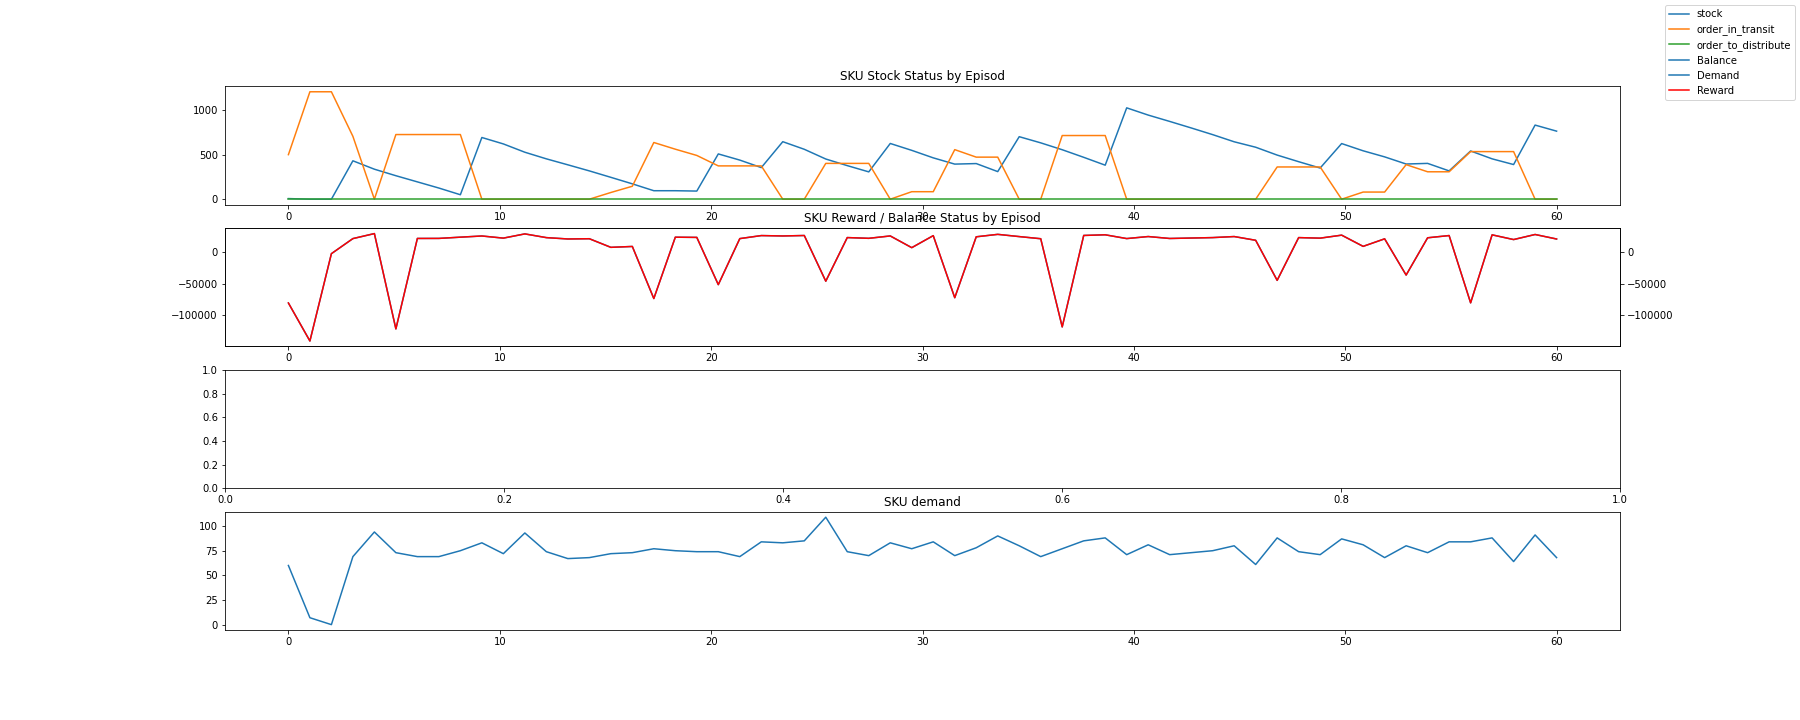

In [30]:
%pylab inline
from IPython.display import display, Image
display(Image(filename='output/RetailerFacility_112_2_productstore.png'))

In [9]:
plt.imshow?